In [259]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Exercise 2.18 : Numerical precision

In [260]:
def f(t, x):
    return 2 * np.power(np.abs(x), 1 / 2)


def f_exact(x, lam):
    return np.power(x - lam, 2) * (x >= lam)

In [261]:
def euler_explicit(N, T, y0, f, type=int, args=()):
    h = T / N
    t = np.linspace(0, T, N + 1)
    y = np.zeros(N + 1, dtype=type)
    y[0] = y0
    for n in range(N):
        y[n + 1] = y[n] + h * f(t[n], y[n], *args)
    return t, y

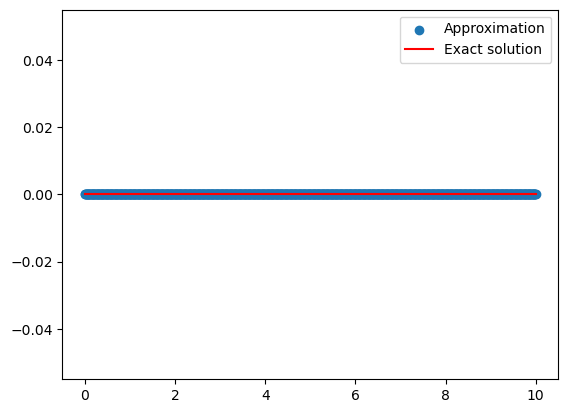

In [262]:
T = 10
N = 1000
u0 = 0

t, sol_appr = euler_explicit(N, T, u0, f)
x = np.linspace(u0, T, 100)

plt.scatter(t, sol_appr, label="Approximation")
plt.plot(x, f_exact(x, T), label="Exact solution", color="red")
plt.legend()
plt.show()

In [263]:
def euler_implicit(N, T, y0):
    h = T / N
    t = np.linspace(0, T, N + 1)
    y = np.zeros(N + 1)
    y[0] = y0
    for n in range(N):
        y[n + 1] = np.power(h + np.sqrt(h ** 2 + y[n]), 2)
    return t, y

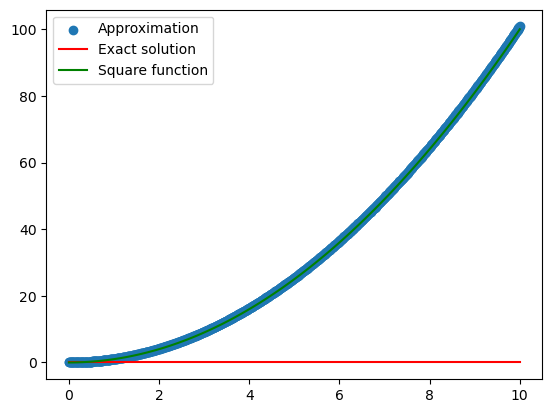

In [264]:
T = 10
N = 1000
u0 = 0

t, sol_appr = euler_implicit(N, T, u0)
x = np.linspace(0, T, 100)

plt.scatter(t, sol_appr, label="Approximation")
plt.plot(x, f_exact(x, T), label="Exact solution", color="red")
plt.plot(x, x ** 2, label="Square function", color="green")
plt.legend()
plt.show()

## Exercise 2.19 : SIR model, schema order

In [265]:
def F(y, t, a, r):
    S, I, R = y
    dS = -r * S * I
    dI = r * S * I - a * I
    dR = a * I
    return np.array([dS, dI, dR])

In [266]:
def euler_explicit_sir(N, T, u0, f, args):
    t = np.linspace(0, T, N + 1)
    y = np.zeros((N + 1, len(y0)))
    y[0] = y0
    h = T / N
    for i in range(N):
        y[i + 1] = y[i] + h * F(y[i], t[i], *args)
    return t, y

In [267]:
def heun_sir(N, T, u0, f, args):
    t = np.linspace(0, T, N + 1)
    y = np.zeros((N + 1, len(y0)))
    y[0] = y0
    h = T / N
    for i in range(N):
        k1 = h * F(y[i], t[i], *args)
        k2 = h * F(y[i] + k1, t[i + 1], *args)
        y[i + 1] = y[i] + 0.5 * (k1 + k2)
    return t, y

In [268]:
def runge_kutta_order_4_sir(N, T, u0, f, args):
    t = np.linspace(0, T, N + 1)
    y = np.zeros((N + 1, len(y0)))
    y[0] = y0
    h = T / N
    for i in range(N):
        k1 = h * F(y[i], t[i], *args)
        k2 = h * F(y[i] + 0.5 * k1, t[i] + 0.5 * h, *args)
        k3 = h * F(y[i] + 0.5 * k2, t[i] + 0.5 * h, *args)
        k4 = h * F(y[i] + k3, t[i + 1], *args)
        y[i + 1] = y[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return t, y

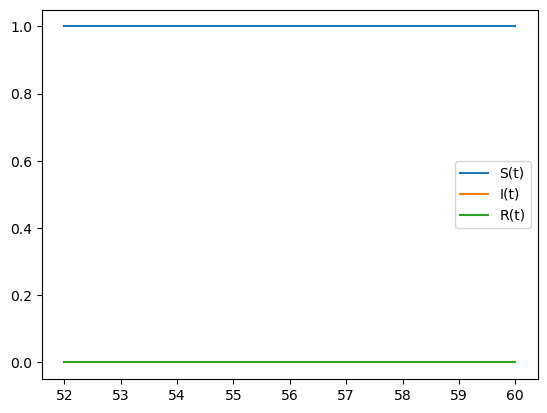

In [269]:
t0, T = 52, 60
N = 150

y0 = np.array([10e6, 10, 0], dtype=np.float64)  # Initial conditions: S, I, R
y0 = y0 / np.sum(y0)  # Normalize initial conditions
a = 0.33  # Recovery rate
r = 0.5  # Infection rate
t = np.linspace(t0, T, N)

sol = odeint(F, y0, t, args=(a, r))

plt.plot(t, sol[:, 0], label='S(t)')
plt.plot(t, sol[:, 1], label='I(t)')
plt.plot(t, sol[:, 2], label='R(t)')
plt.legend()
plt.show()

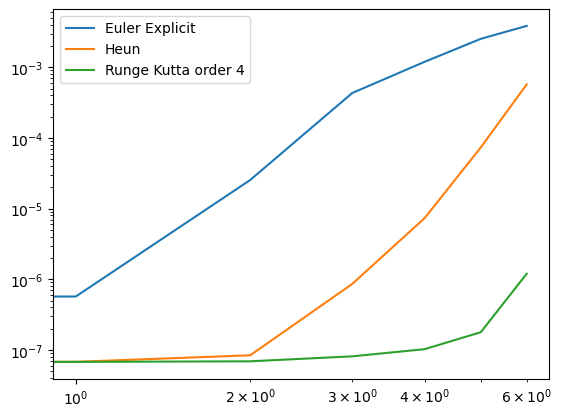

In [270]:
errors_EE = []
errors_H = []
errors_RK4 = []

h_list = [0.05, 0.01, 0.1, 0.5, 1, 2, 4]


def calculate_errors(sol_exact, sol_appr):
    return np.max(
        np.power(np.abs(sol_appr - sol_exact), 2)[np.isfinite(np.power(np.abs(sol_appr - sol_exact), 2))]
    )


for h in h_list:
    N = int(T / h)
    t = np.linspace(0, T, N + 1)

    _, sol_appr_EE = euler_explicit_sir(N, T, y0, F, args=(a, r))
    _, sol_appr_H = heun_sir(N, T, y0, F, args=(a, r))
    _, sol_appr_RK4 = runge_kutta_order_4_sir(N, T, y0, F, args=(a, r))
    sol_exact = odeint(F, y0, t, args=(a, r))

    errors_EE.append(calculate_errors(sol_exact, sol_appr_EE))
    errors_H.append(calculate_errors(sol_exact, sol_appr_H))
    errors_RK4.append(calculate_errors(sol_exact, sol_appr_RK4))

plt.plot(errors_EE, label="Euler Explicit")
plt.plot(errors_H, label="Heun")
plt.plot(errors_RK4, label="Runge Kutta order 4")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

## Exercise 2.20 : Stability of Euler Explicit

In [271]:
def euler_implicit(N, T, u0, lam, type=int):
    h = T / N
    t = np.linspace(0, T, N + 1)
    u = np.zeros(N + 1, dtype=type)
    u[0] = u0
    for n in range(N):
        u[n + 1] = u[n] / (1 - lam * h)
    return t, u

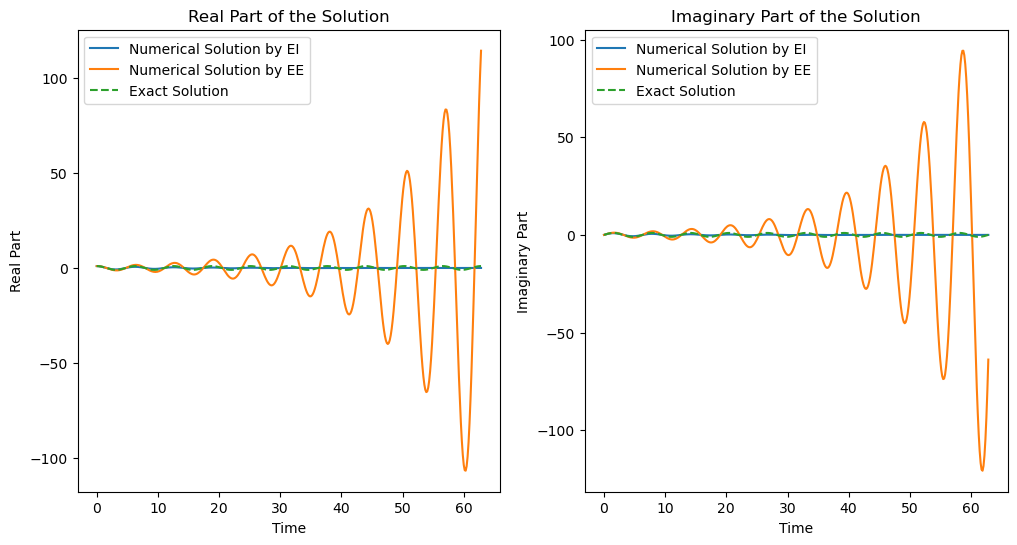

In [272]:
def f(t, x, lam):
    return x * lam


T = 10 * 2 * np.pi
lam = 1j
N = 400
x0 = 1

t, x_appr_EE = euler_explicit(N, T, x0, f, type=complex, args=(lam,))
_, x_appr_EI = euler_implicit(N, T, x0, lam, type=complex)
x_exact = x0 * np.exp(lam * t)

# Plot the real parts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, np.real(x_appr_EI), label='Numerical Solution by EI')
plt.plot(t, np.real(x_appr_EE), label='Numerical Solution by EE')
plt.plot(t, np.real(x_exact), label='Exact Solution', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Real Part')
plt.legend()
plt.title('Real Part of the Solution')

# Plot the imaginary parts
plt.subplot(1, 2, 2)
plt.plot(t, np.imag(x_appr_EI), label='Numerical Solution by EI')
plt.plot(t, np.imag(x_appr_EE), label='Numerical Solution by EE')
plt.plot(t, np.imag(x_exact), label='Exact Solution', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Imaginary Part')
plt.legend()
plt.title('Imaginary Part of the Solution')

plt.show()